# Transformer
:label:`sec_transformer`

我们在 :numref:`subsec_cnn-rnn-self-attention` 中比较了 CNN、RNN 和自注意力。值得注意的是，自注意力同时具有并行计算和最短的最大路径长度这两个优势。因此，通过使用自注意力来设计深层架构是很有吸引力的。与之前仍然依赖 RNN 进行输入表示 :cite:`Cheng.Dong.Lapata.2016,Lin.Feng.Santos.ea.2017,Paulus.Xiong.Socher.2017` 的自注意力模型不同，Transformer 模型完全基于注意力机制，没有任何卷积层或循环层 :cite:`Vaswani.Shazeer.Parmar.ea.2017`。尽管 Transformer 最初是应用于文本数据的序列学习，但已经普遍应用在各种现代的深度学习中，例如语言、视觉、语音和强化学习领域。

## 模型

作为“编码器－解码器”架构的一个实例，Transformer 的整体架构在图 :numref:`fig_transformer` 中呈现。正如所见到的，Transformer 由编码器和解码器组成。与 :numref:`fig_s2s_attention_details` 中 Bahdanau 注意力的序列到序列的学习相比，Transformer 的编码器和解码器是由基于自注意力的模块叠加而成的，输入（源）和输出（目标）序列的嵌入 (embedding) 将被叠加上位置编码，再一起输入到编码器和解码器中。

![The Transformer architecture.](../img/transformer.svg)
:width:`500px`
:label:`fig_transformer`

现在为止图 :numref:`fig_transformer` 中已经概述了 Transformer 的架构。从宏观角度来看，Transformer 的编码器是由多个相同的层叠加而成的，每个层都有两个子层（子层表示为 $\mathrm{sublayer}$）。第一个子层是多头自注意力池化，第二个子层是基于位置的前馈网络 (positionwise feed-forward network)。具体来说，在计算编码器的自注意力时，查询、键和值都来自前一个编码器层的输出。受 :numref:`sec_resnet` ResNet 设计的启发，每个子层都采用了残差连接 (residual connection)。在 Transformer 中，对于序列中任何位置的任何输入 $\mathbf{x} \in \mathbb{R}^d$，我们要求满足 $\mathrm{sublayer}(\mathbf{x}) \in \mathbb{R}^d$，以便残差连接 $\mathbf{x} + \mathrm{sublayer}(\mathbf{x}) \in \mathbb{R}^d$ 是可行的。在残差连接的加法计算之后，紧接着层归一化 (layer normalization) :cite:`Ba.Kiros.Hinton.2016`。因此，对应输入序列的每个位置，Transformer 编码器输出 $d$ 维向量进行表示。

Transformer 解码器也是由多个相同的使用了残差连接和层归一化的层叠加而成。除了编码器中描述的两个子层之外，解码器还在这两个子层之间插入第三个子层，称为”编码器－解码器“注意力 (encoder-decoder attention)。在“编码器－解码器”注意力中，查询来自前一个解码器层的输出，而键和值来自 Transformer 编码器的输出。在解码器自注意力中，查询、键和值都来自上一个解码器层的输出。但是，解码器中的每个位置只能考虑该位置之前的所有位置。这种 * 掩码 * 注意力保留了自回归属性，确保预测仅依赖于已生成的输出令牌。

我们已经描述并实现了基于缩放的“点－积” :numref:`sec_multihead-attention` 和位置编码 :numref:`subsec_positional-encoding` 的多头注意力。接下来，我们将实现 Transformer 模型的其余部分。


In [1]:
import math
import pandas as pd
from mxnet import autograd, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

## 基于位置的前馈网络

基于位置的前馈网络使用同一个多层感知机，对序列中的所有位置的表示进行了变换。这就是 *基于位置的* (positionwise) 的原因。在下面的实现中，输入 `X` 的形状（批量大小、时间步长或序列长度、隐单元数或特征维度）将被双层感知机转换成形状为（批量大小、时间步长、前馈网络输出单元数）的输出张量。


In [2]:
#@save
class PositionWiseFFN(nn.Block):
    def __init__(self, ffn_num_hiddens, ffn_num_outputs, **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Dense(ffn_num_hiddens, flatten=False,
                               activation='relu')
        self.dense2 = nn.Dense(ffn_num_outputs, flatten=False)

    def forward(self, X):
        return self.dense2(self.dense1(X))

下面的例子显示，张量的最内层维度的尺寸会改变成基于位置的前馈网络的输出尺寸。由于相同的多层感知机对所有位置上的输入都进行了变换，所以当所有这些位置的输入相同时，它们的输出也是相同的。


In [3]:
ffn = PositionWiseFFN(4, 8)
ffn.initialize()
ffn(np.ones((2, 3, 4)))[0]

array([[ 0.00239431,  0.00927085, -0.00021069, -0.00923989, -0.0082903 ,
        -0.00162741,  0.00659031,  0.00023905],
       [ 0.00239431,  0.00927085, -0.00021069, -0.00923989, -0.0082903 ,
        -0.00162741,  0.00659031,  0.00023905],
       [ 0.00239431,  0.00927085, -0.00021069, -0.00923989, -0.0082903 ,
        -0.00162741,  0.00659031,  0.00023905]])

## 残差连接和层归一化

现在让我们关注 :numref:`fig_transformer` 中的 “加法和归一化” 组件。正如在本节开头所述，这是由残差连接和紧随的层归一化组成的。两者都是有效的深度架构的关键。

在 :numref:`sec_batch_norm` 中，我们解释了如何在一个小批量内通过批量标准化对样本数据进行重新中心化和重新缩放的调整。层归一化和批量归一化相同，只是前者基于特征维度进行归一化。尽管批量归一化在计算机视觉中被广泛应用，但在自然语言处理任务中（输入通常是变长序列）批量归一化的效果通常不如层归一化的好。

以下代码段对比了不同维度的层归一化和批量归一化的归一化效果。


In [4]:
ln = nn.LayerNorm()
ln.initialize()
bn = nn.BatchNorm()
bn.initialize()
X = np.array([[1, 2], [2, 3]])
# 在训练模式下计算 `X` 的均值和方差
with autograd.record():
    print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: [[-0.99998  0.99998]
 [-0.99998  0.99998]] 
batch norm: [[-0.99998 -0.99998]
 [ 0.99998  0.99998]]


现在我们可以使用残差连接和层归一化来实现 `AddNorm` 类。Dropout 也被作为正规化方法用在这里。


In [5]:
#@save
class AddNorm(nn.Block):
    def __init__(self, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm()

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

残差连接要求两个输入的形状相同，以便在加法操作后输出的张量也具有相同的形状。


In [6]:
add_norm = AddNorm(0.5)
add_norm.initialize()
add_norm(np.ones((2, 3, 4)), np.ones((2, 3, 4))).shape

(2, 3, 4)

## 编码器

现在有了组成 Transformer 编码器的基础组件，可以先实现编码器中的一个层。下面的 `EncoderBlock` 类包含两个子层：多头自注意力和基于位置的前馈网络，围绕着这两个子层都使用了残差连接和紧随的层归一化。


In [7]:
#@save
class EncoderBlock(nn.Block):
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout,
                 use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.addnorm1 = AddNorm(dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

正如我们所看到的，Transformer 编码器中的任何层都不会改变其输入的形状。


In [8]:
X = np.ones((2, 100, 24))
valid_lens = np.array([3, 2])
encoder_blk = EncoderBlock(24, 48, 8, 0.5)
encoder_blk.initialize()
encoder_blk(X, valid_lens).shape

(2, 100, 24)

在下面的 Transformer 编码器的实现中，我们堆叠了 `num_layers` 个 `EncoderBlock` 类的实例。由于我们使用的是值范围在-1 和 1 之间的固定位置编码，因此在与位置编码相加之前，将可以学习的输入嵌入的值乘以嵌入维度的平方根进行重新缩放。


In [9]:
#@save
class TransformerEncoder(d2l.Encoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for _ in range(num_layers):
            self.blks.add(
                EncoderBlock(num_hiddens, ffn_num_hiddens, num_heads, dropout,
                             use_bias))

    def forward(self, X, valid_lens, *args):
        # 因为位置编码值在 -1 和 1 之间，
        # 因此嵌入值乘以嵌入维度的平方根进行缩放，
        # 然后再与位置编码相加。
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

下面我们指定了超参数来创建一个双层 Transformer 编码器。Transformer 编码器输出的形状是（批量大小、时间步长、`num_hiddens`）。


In [10]:
encoder = TransformerEncoder(200, 24, 48, 8, 2, 0.5)
encoder.initialize()
encoder(np.ones((2, 100)), valid_lens).shape

(2, 100, 24)

## 解码器

如 :numref:`fig_transformer` 所示，Transformer 解码器由多个相同的层组成。`DecoderBlock` 类中包含三个子层：解码器自注意力、“编码器-解码器”注意力和基于位置的前馈网络，每个子层都已经被实现。这些子层也都采用了残差连接和紧随的层归一化。

正如在本节前面所述，在解码器的掩码多头自注意力（第一个子层）中，查询、键和值都来自上一个解码器层的输出。在序列到序列模型 (sequence-to-sequence models) 的训练阶段，输出序列的所有位置（时间步）的令牌都是已知的。但在预测阶段，输出序列是通过令牌一个接着一个生成的；因此，在任何解码器时间步中，只有生成的令牌才能用于解码器的自注意力计算中。为了在解码器中保留自回归的属性，其掩码自注意力指定了参数 `dec_valid_lens`，以便任何查询只会与解码器已经生成的所有位置（直到该查询位置为止）进行注意力计算。


In [11]:
class DecoderBlock(nn.Block):
    """解码器中第 i 个块"""
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i,
                 **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm1 = AddNorm(dropout)
        self.attention2 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm2 = AddNorm(dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # 训练阶段，输出序列的所有令牌都在同一时间处理，
        # 因此 `state[2][self.i]` 初始化为 `None`。
        # 预测阶段，输出序列是通过令牌一个接着一个解码的，
        # 因此 `state[2][self.i]` 包含着直到当前时间步第 `i` 个块解码的输出表示
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = np.concatenate((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values

        if autograd.is_training():
            batch_size, num_steps, _ = X.shape
            # `dec_valid_lens` 的开头: (`batch_size`, `num_steps`),
            # 其中每一行是 [1, 2, ..., `num_steps`]
            dec_valid_lens = np.tile(np.arange(1, num_steps + 1, ctx=X.ctx),
                                     (batch_size, 1))
        else:
            dec_valid_lens = None

        # 自注意力
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # “编码器－解码器”注意力。
        # 'enc_outputs' 的开头: ('batch_size', 'num_steps', 'num_hiddens')
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

为了便于在“编码器－解码器”注意力中进行缩放的“点－积”计算和残差连接中进行加法操作，编码器和解码器的特征维度相同，都是 (`num_hiddens`)。


In [12]:
decoder_blk = DecoderBlock(24, 48, 8, 0.5, 0)
decoder_blk.initialize()
X = np.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

(2, 100, 24)

现在我们构建了由 `num_layers` 个 `DecoderBlock` 实例组成的完整的 Transformer 解码器。最后，通过一个全连接层计算所有 `vocab_size` 个可能的输出令牌的预测值。解码器的自注意力权重和“编码器－解码器”的注意力权重都被存储下来，以供日后可视化。


In [13]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add(
                DecoderBlock(num_hiddens, ffn_num_hiddens, num_heads, dropout,
                             i))
        self.dense = nn.Dense(vocab_size, flatten=False)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 解码器自注意力权重
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # “编码器－解码器”自注意力权重
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

## 训练

依照 Transformer 架构来实例化“编码器－解码器”模型。在这里，指定 Transformer 的编码器和解码器都是 2 层，使用 4 头注意力。与 :numref:`sec_seq2seq_training` 类似，为了进行序列到序列的学习，我们在英语到法语的机器翻译数据集上训练 Transformer 模型。


loss 0.031, 2494.4 tokens/sec on gpu(0)


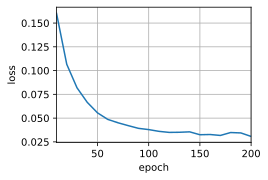

In [14]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_hiddens, num_heads = 64, 4

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(len(src_vocab), num_hiddens, ffn_num_hiddens,
                             num_heads, num_layers, dropout)
decoder = TransformerDecoder(len(tgt_vocab), num_hiddens, ffn_num_hiddens,
                             num_heads, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

训练结束后，使用 Transformer 模型将一些英语句子翻译成法语，并且计算它们的 BLEU 分数。


In [15]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000


i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est bon .,  bleu 0.658


i'm home . => je suis chez moi .,  bleu 1.000


在翻译最后一个英语句子时，对 Transformer 的注意力权重进行可视化。编码器自注意力权重的形状为（编码器层数、注意力头数、`num_steps`或查询个数、`num_steps` 或“键－值”对的数量）。


In [16]:
enc_attention_weights = np.concatenate(net.encoder.attention_weights,
                                       0).reshape((num_layers, num_heads, -1,
                                                   num_steps))
enc_attention_weights.shape

(2, 4, 10, 10)

在编码器的自注意力中，查询和键来自相同的输入序列。由于填充的令牌不具有意义，因此通过指定输入序列的有效长度，避免对填充的位置计算注意力。接下来，将逐行呈现两层多头注意力权重。每个注意力头都根据查询、键和值的不同的表示子空间来表示不同的注意力。


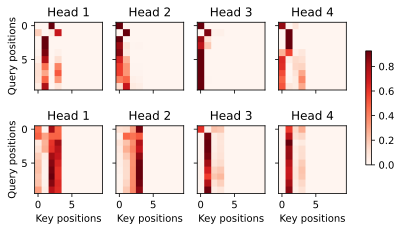

In [17]:
d2l.show_heatmaps(enc_attention_weights, xlabel='Key positions',
                  ylabel='Query positions',
                  titles=['Head %d' % i
                          for i in range(1, 5)], figsize=(7, 3.5))

为了可视化解码器的自注意力权重和“编码器－解码器”的注意力权重，我们需要做更多的数据操作。例如，我们用零填充被掩码覆盖的注意力权重。值得注意的是，解码器的自注意力权重和“编码器－解码器”的注意力权重都有相同的查询：即以序列开始令牌 (beginning-of-sequence, BOS) 开头，及后续逐个生成的令牌序列。


In [18]:
dec_attention_weights_2d = [
    np.array(head[0]).tolist() for step in dec_attention_weight_seq
    for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = np.array(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape(
    (-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.transpose(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

((2, 4, 6, 10), (2, 4, 6, 10))

由于解码器自注意力的自回归属性，查询不会对当前位置之后的“键－值”对进行注意力计算。


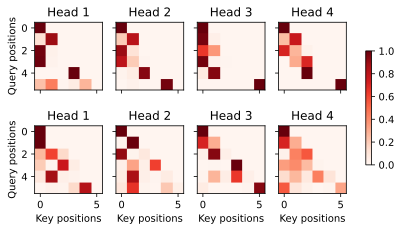

In [19]:
# Plus one to include the beginning-of-sequence token
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

与编码器自注意力的情况类似，通过指定输入序列的有效长度，输出序列中的任何查询都不会与输入序列中的填充位置的令牌进行注意力计算。


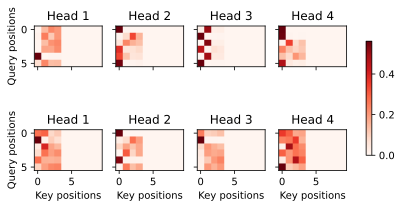

In [20]:
d2l.show_heatmaps(dec_inter_attention_weights, xlabel='Key positions',
                  ylabel='Query positions',
                  titles=['Head %d' % i
                          for i in range(1, 5)], figsize=(7, 3.5))

尽管 Transformer 架构是为了序列到序列的学习而提出的，但正如我们将在本书后面提及的那样，Transformer 编码器或 Transformer 解码器通常被单独用于不同的深度学习任务中。

## 小结

* Transformer 是“编码器－解码器”架构的一个实例，尽管在实践中编码器或解码器可以单独使用。
* 在 Transformer 中，多头自注意力用于表示输入序列和输出序列，尽管解码器必须通过掩码机制来保留自回归属性。
* Transformer 中的残差连接和层归一化对于训练非常深度的模型很重要。
* Transformer 模型中的基于位置的前馈网络使用相同的多层感知机，对序列的所有位置的表示进行转换。

## 练习

1. 在实验中训练更深的 Transformer 将如何影响训练速度和翻译效果？
1. 在 Transformer 中用可加性注意力取代缩放的“点－积”注意力是不是个好办法？为什么？
1. 对于语言模型，我们应该使用 Transformer 的编码器或者解码器还是两者都用？如何设计？
1. 如果输入序列很长， Transformer 会面临什么挑战？为什么？
1. 如何提高 Transformer 的计算和内存效率？提示：可以参考 Tay et al. 的论文 :cite:`Tay.Dehghani.Bahri.ea.2020`。
1. 如何在不使用 CNN 的情况下为图像分类任务设计基于 Transformer 的模型？提示：可以参考 Vision Transformer :cite:`Dosovitskiy.Beyer.Kolesnikov.ea.2021`。


[Discussions](https://discuss.d2l.ai/t/348)
